In [ ]:
import os
import itertools
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import xgboost as xgb
import shap


In [2]:
df_features = pd.read_csv("data/merged_features.csv", index_col=0, parse_dates=True)

In [3]:
PROJECT_DIR = Path.cwd()
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
OUT_DIR = os.path.join(PROJECT_DIR, 'output')
for d in [DATA_DIR, OUT_DIR]:
    os.makedirs(d, exist_ok=True)

XGBoost model

In [ ]:


def run_xgboost_sliding_window(
    df,
    feature_cols=None,
    target_col="Target_Log_RV",
    initial_train_size=2000,
    test_window_size=20,
):
    """
    Rolling-window XGBoost forecaster for log realised volatility.
    Stores raw SHAP values for test windows to allow global Beeswarm/Interaction plots.
    """

    # 0. Default feature list
    if feature_cols is None:
        feature_cols = [
            'Relative_Volume', 'True_Range_S&P', 'Momentum_1D_gold',
            'Momentum_1D_oil', 'Momentum_1D_yield', 'Corr_SP_Gold', 'Corr_SP_Oil',
            'Corr_SP_DGS10', 'True_Range_Oil', 'True_Range_Gold', 'Vol_GK_Oil',
            'Vol_GK_Gold', 'Log_VIX', 'Log_VIX_Change', 'Log_RV_Daily',
            'Log_RV_Weekly', 'Log_RV_Monthly', 'Kurtosis_60D',
            'Momentum_1D_sp', 'Momentum_1W_sp', 'Momentum_1M_sp', 'RSI_14'
        ]

    # 1. Prepare data
    data = df.copy()
    data = data.dropna(subset=[target_col])

    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)

    X_all = data[feature_cols]
    y_all = data[target_col].values

    # Storage
    predictions_log = []
    actuals_log = []
    prediction_dates = []

    train_r2_list = []
    val_r2_list = []
    test_r2_list = []
    window_end_dates = []

    # Store feature importances per window
    feature_importance_list = []

    # SHAP storage: List of matrices (one per window)
    shap_window_list = []

    current_idx = initial_train_size
    n_samples = len(data)

    print("Starting rolling XGBoost forecast...")

    # 2. Rolling loop
    while current_idx < n_samples:

        test_end_idx = min(current_idx + test_window_size, n_samples)
        if test_end_idx <= current_idx:
            break

        print(f"\nWindow: Train[0:{current_idx}] -> Test[{current_idx}:{test_end_idx}]")

        # Split
        X_train = X_all.iloc[:current_idx]
        y_train = y_all[:current_idx]

        X_test = X_all.iloc[current_idx:test_end_idx]
        y_test = y_all[current_idx:test_end_idx]
        dates_test = data.index[current_idx:test_end_idx]

        # Chronological train/validation split
        val_fraction = 0.2
        val_size = int(len(X_train) * val_fraction)

        X_train_fit = X_train.iloc[:-val_size]
        y_train_fit = y_train[:-val_size]

        X_val = X_train.iloc[-val_size:]
        y_val = y_train[-val_size:]

        # Hyperparameter grid
        param_grid = {
            "max_depth": [2, 3],
            "learning_rate": [0.05, 0.1],
            "subsample": [0.7, 0.9],
            "colsample_bytree": [0.7, 0.9],
            "reg_lambda": [5, 10],
            "reg_alpha": [0, 1],
        }

        best_val = np.inf
        best_params = None

        # Grid search
        for md, lr, ss, cs, lam, alp in itertools.product(
            param_grid["max_depth"], param_grid["learning_rate"],
            param_grid["subsample"], param_grid["colsample_bytree"],
            param_grid["reg_lambda"], param_grid["reg_alpha"]
        ):
            model = xgb.XGBRegressor(
                objective="reg:squarederror", max_depth=md, learning_rate=lr,
                subsample=ss, colsample_bytree=cs, reg_lambda=lam, reg_alpha=alp,
                n_estimators=300, random_state=42, tree_method="hist"
            )
            model.fit(X_train_fit, y_train_fit)
            preds_val = model.predict(X_val)
            val_rmse = np.sqrt(mean_squared_error(y_val, preds_val))

            if val_rmse < best_val:
                best_val = val_rmse
                best_params = (md, lr, ss, cs, lam, alp)

        print("Best params:", best_params)

        # Final model (train + val)
        md, lr, ss, cs, lam, alp = best_params

        final_model = xgb.XGBRegressor(
            objective="reg:squarederror", max_depth=md, learning_rate=lr,
            subsample=ss, colsample_bytree=cs, reg_lambda=lam, reg_alpha=alp,
            n_estimators=300, random_state=42, tree_method="hist"
        )

        final_model.fit(X_train, y_train)

        # Store split-based feature importances
        fi = final_model.feature_importances_
        feature_importance_list.append(fi)

        # =========================================================
        # CORRECT SHAP STORAGE FOR PLOTS
        # =========================================================
        explainer = shap.TreeExplainer(final_model)
        
        # Calculate raw SHAP values for the TEST data (the predictions)
        # We save the raw matrix to enable Beeswarm/Interaction plots later.
        shap_values_test = explainer.shap_values(X_test)
        
        shap_window_list.append(shap_values_test)
        # =========================================================

        # Predictions
        train_pred = final_model.predict(X_train_fit)
        val_pred = final_model.predict(X_val)
        pred_test = final_model.predict(X_test)
        test_r2 = r2_score(y_test, pred_test)

        # Store predictions
        predictions_log.extend(pred_test)
        actuals_log.extend(y_test)
        prediction_dates.extend(dates_test)

        train_r2_list.append(r2_score(y_train_fit, train_pred))
        val_r2_list.append(r2_score(y_val, val_pred))
        test_r2_list.append(test_r2)
        window_end_dates.append(dates_test[-1])

        current_idx += test_window_size

    # 3. Final metrics
    pred_log = np.array(predictions_log)
    actual_log = np.array(actuals_log)
    pred_vol = np.exp(pred_log)
    actual_vol = np.exp(actual_log)

    mse = mean_squared_error(actual_vol, pred_vol)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_vol, pred_vol)

    ss_res = np.sum((actual_vol - pred_vol) ** 2)
    ss_tot = np.sum((actual_vol - actual_vol.mean()) ** 2)
    r2_mean = 1 - ss_res / ss_tot

    y_true, y_pred = actual_vol, pred_vol
    num = np.sum((y_true[1:] - y_pred[1:]) ** 2)
    den = np.sum((y_true[1:] - y_true[:-1]) ** 2)
    r2_rw = 1 - num / den

    # 4. Build SHAP outputs
    # Stack all window matrices into one large matrix
    shap_matrix = np.vstack(shap_window_list)
    
    # Create a DataFrame indexed by date
    shap_values_df = pd.DataFrame(
        shap_matrix,
        index=pd.to_datetime(prediction_dates),
        columns=feature_cols
    )

    print("\n====== XGBoost Rolling Forecast Performance ======")
    print(f"RMSE (vol):            {rmse:.6f}")
    print(f"MAE  (vol):            {mae:.6f}")
    print(f"R2 (vs mean, XGBoost): {r2_mean:.6f}")
    print(f"R2 (vs RW, XGBoost):   {r2_rw:.6f}")
    print("=================================================")

    # 5. Build results_df
    results_df = pd.DataFrame({
        "Pred_Log": pred_log, "True_Log": actual_log,
        "Pred_Vol": pred_vol, "True_Vol": actual_vol
    }, index=pd.to_datetime(prediction_dates))

    # 6. Build feature importance DF
    fi_df = pd.DataFrame(
        np.vstack(feature_importance_list),
        index=pd.to_datetime(window_end_dates),
        columns=feature_cols
    )

    # 7. Return
    metrics = {
        "RMSE": rmse, "MAE": mae, "R2_mean": r2_mean, "R2_RW": r2_rw,
        "R2_windows": pd.DataFrame({
            "Train_R2": train_r2_list, "Val_R2": val_r2_list, "Test_R2": test_r2_list
        }, index=pd.to_datetime(window_end_dates)),
        "Feature_Importance": fi_df,
        "SHAP_Values": shap_values_df  # <--- Raw SHAP matrix for your plots
    }

    return results_df, metrics

In [5]:
# 1. Run the function
results, metrics = run_xgboost_sliding_window(df_features)

Starting rolling XGBoost forecast...

Window: Train[0:2000] -> Test[2000:2020]
Best params: (2, 0.1, 0.9, 0.7, 10, 0)

Window: Train[0:2020] -> Test[2020:2040]
Best params: (2, 0.1, 0.9, 0.7, 5, 1)

Window: Train[0:2040] -> Test[2040:2060]
Best params: (2, 0.1, 0.9, 0.7, 5, 0)

Window: Train[0:2060] -> Test[2060:2080]
Best params: (2, 0.1, 0.9, 0.7, 5, 0)

Window: Train[0:2080] -> Test[2080:2100]
Best params: (2, 0.1, 0.9, 0.9, 5, 1)

Window: Train[0:2100] -> Test[2100:2120]
Best params: (3, 0.1, 0.7, 0.7, 5, 0)

Window: Train[0:2120] -> Test[2120:2140]
Best params: (2, 0.1, 0.9, 0.9, 10, 0)

Window: Train[0:2140] -> Test[2140:2160]
Best params: (2, 0.1, 0.9, 0.7, 10, 0)

Window: Train[0:2160] -> Test[2160:2180]
Best params: (2, 0.1, 0.7, 0.7, 5, 1)

Window: Train[0:2180] -> Test[2180:2200]
Best params: (2, 0.1, 0.9, 0.7, 5, 1)

Window: Train[0:2200] -> Test[2200:2220]
Best params: (2, 0.1, 0.9, 0.9, 5, 0)

Window: Train[0:2220] -> Test[2220:2240]
Best params: (2, 0.1, 0.9, 0.7, 10, 0)

-------------------------------------------


Graph saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\xgboost_forecast_results.pdf


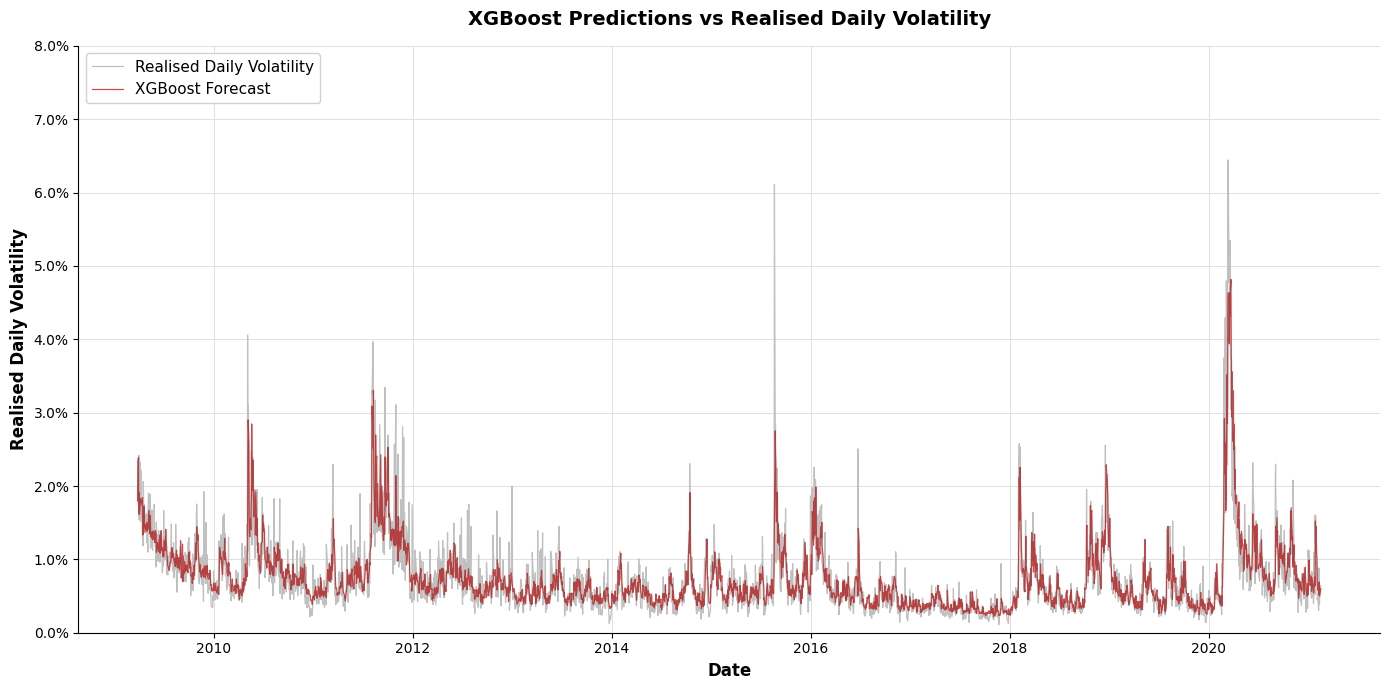

In [6]:
# Extract data and convert to %
plot_dates = results.index
true_pct   = results["True_Vol"] * 100
pred_pct   = results["Pred_Vol"] * 100

plt.figure(figsize=(14, 7))

# Realised volatility (grey)
plt.plot(
    plot_dates,
    true_pct,
    color="silver",
    linewidth=0.9,
    alpha=1.0,
    label="Realised Daily Volatility"
)

# XGBoost forecast (red)
plt.plot(
    plot_dates,
    pred_pct,
    color="firebrick",
    linewidth=0.9,
    alpha=0.8,
    label="XGBoost Forecast"
)

# Styling (same as GARCH / EGARCH)
plt.title("XGBoost Predictions vs Realised Daily Volatility",
          fontsize=14, fontweight="bold", pad=15)
plt.ylabel("Realised Daily Volatility", fontsize=12, fontweight="bold")
plt.xlabel("Date", fontsize=12, fontweight="bold")

ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
ax.grid(True, color="#e0e0e0", linestyle='-', linewidth=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, 8)   # 0%–8% like EGARCH/GARCH

plt.legend(frameon=True, fontsize=11, loc="upper left", framealpha=0.9)
plt.tight_layout()

try:
    save_path = os.path.join(OUT_DIR, 'xgboost_forecast_results.pdf')
    plt.savefig(save_path, format='pdf', bbox_inches='tight')
    print(f"Graph saved to: {save_path}")
except NameError:
    print("Could not save PDF (OUT_DIR not defined).")



plt.show()


In [7]:
#Save the results for multi plotting:
results.to_csv("results_xgboost.csv")
metrics.to_csv("metrics_xgboost.csv")

AttributeError: 'dict' object has no attribute 'to_csv'

In [8]:
metrics

{'RMSE': np.float64(0.0029849239469484003),
 'MAE': 0.0018166564051208228,
 'R2_mean': np.float64(0.6925968054462586),
 'R2_RW': np.float64(0.3240086923741514),
 'R2_windows':             Train_R2    Val_R2   Test_R2
 2009-04-24  0.805820  0.869909 -0.150385
 2009-05-22  0.798446  0.862153  0.028723
 2009-06-22  0.806541  0.857971 -0.275353
 2009-07-21  0.802620  0.860246 -0.249767
 2009-08-18  0.796553  0.852259 -0.076578
 ...              ...       ...       ...
 2020-11-11  0.784987  0.822050 -0.092519
 2020-12-10  0.787760  0.825189 -0.699159
 2021-01-12  0.771377  0.810452 -0.199767
 2021-02-10  0.785470  0.813094  0.211656
 2021-02-16  0.772511  0.797337 -0.374300
 
 [150 rows x 3 columns],
 'Feature_Importance':             Relative_Volume  True_Range_S&P  Momentum_1D_gold  \
 2009-04-24         0.005745        0.014564          0.003715   
 2009-05-22         0.004752        0.010373          0.002752   
 2009-06-22         0.005367        0.013002          0.003006   
 2009-07

Let's check features importances.

Top K inclusion frequency

Top features by Top-5 inclusion frequency (XGBoost):
                SelectionFreq  MeanImportance
Log_RV_Weekly      100.000000        0.352134
Log_VIX            100.000000        0.339352
Log_RV_Daily       100.000000        0.105785
RSI_14             100.000000        0.037021
Momentum_1M_sp     100.000000        0.017581
Momentum_1W_sp     100.000000        0.016433
Momentum_1D_sp     100.000000        0.012443
Log_RV_Monthly      99.333333        0.039184
True_Range_S&P      92.000000        0.010849
Log_VIX_Change      87.333333        0.008227
Graph saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\xgboos_features_importance_map_top7.pdf


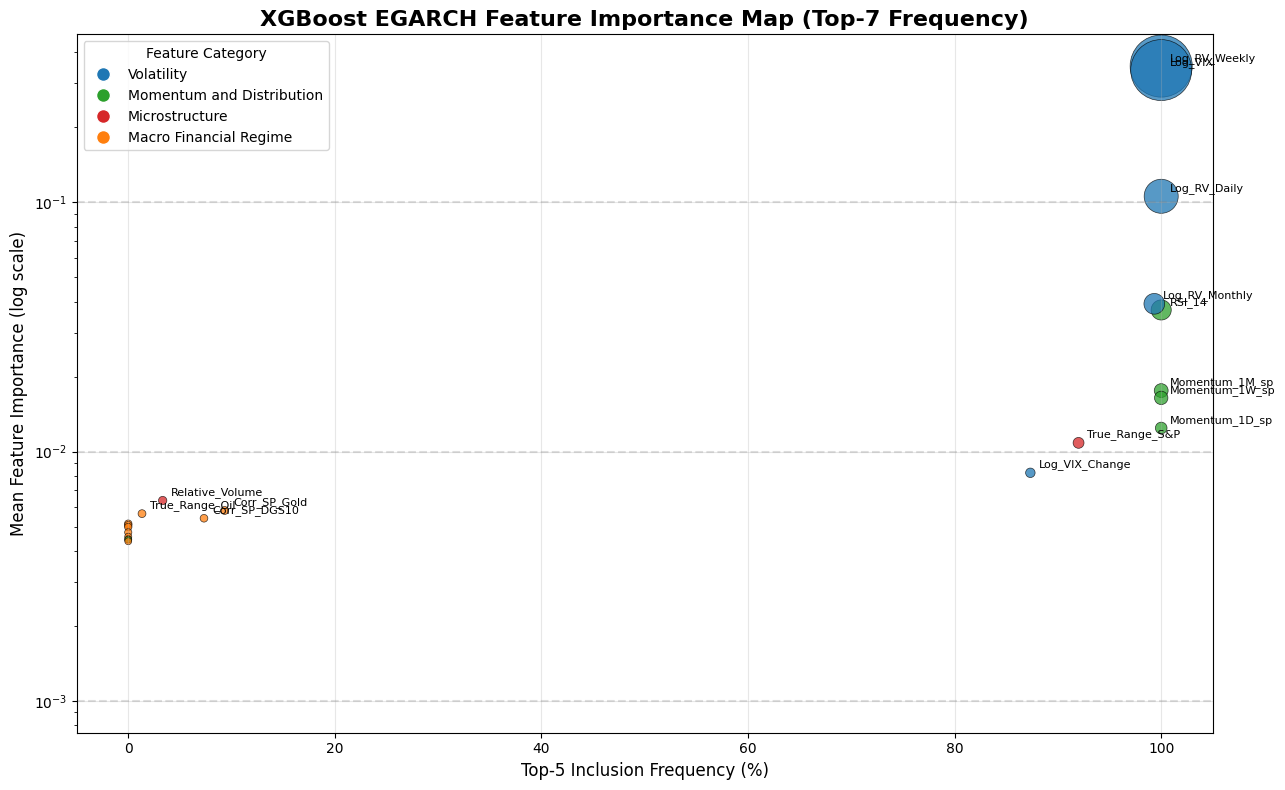

In [ ]:


# ==========================================
# 0. Helper: Top-K inclusion frequency
# ==========================================
def top_k_frequency(fi_df, k=5):
    """
    Compute the percentage of rolling windows in which each feature
  
    """
    topk_freq = pd.Series(0, index=fi_df.columns, dtype=float)

    for _, row in fi_df.iterrows():
        # Identify top-k features in this window (by importance)
        topk = row.nlargest(k).index
        topk_freq[topk] += 1

    # Convert to percentage
    return (topk_freq / len(fi_df)) * 100


# ==========================================
# 1. Get rolling feature importance from XGBoost
# ==========================================
# After running:
# results_xgb, metrics_xgb = run_xgboost_sliding_window(df)
# you should have:
fi_df = metrics["Feature_Importance"].copy()
# rows = window end dates, columns = features, values = importance per window


# ==========================================
# 2. Compute summary statistics
# ==========================================

# Top-K inclusion frequency (instead of (fi_df > 0))
selection_freq = top_k_frequency(fi_df, k=10)

# Mean feature importance across windows
mean_imp = fi_df.mean()

importance_df = pd.DataFrame({
    "SelectionFreq": selection_freq,
    "MeanImportance": mean_imp
})

# Sort mostly by selection frequency, then by mean importance
importance_df = importance_df.sort_values(
    ["SelectionFreq", "MeanImportance"],
    ascending=[False, False]
)

print("Top features by Top-5 inclusion frequency (XGBoost):")
print(importance_df.head(10))


# ==========================================
# 3. Manual feature classification (same as ElasticNet)
# ==========================================
feature_categories = {
    'Relative_Volume':      'Microstructure',
    'True_Range_S&P':       'Microstructure',

    'Momentum_1D_gold':     'Macro Financial Regime',
    'Momentum_1D_oil':      'Macro Financial Regime',
    'Momentum_1D_yield':    'Macro Financial Regime',
    'Corr_SP_Gold':         'Macro Financial Regime',
    'Corr_SP_Oil':          'Macro Financial Regime',
    'Corr_SP_DGS10':        'Macro Financial Regime',
    'True_Range_Oil':       'Macro Financial Regime',
    'True_Range_Gold':      'Macro Financial Regime',
    'Vol_GK_Oil':           'Macro Financial Regime',
    'Vol_GK_Gold':          'Macro Financial Regime',

    'Log_VIX':              'Volatility',
    'Log_VIX_Change':       'Volatility',
    'Log_RV_Daily':         'Volatility',
    'Log_RV_Weekly':        'Volatility',
    'Log_RV_Monthly':       'Volatility',
    'Target_Log_RV':        'Target',

    'EGARCH_Omega':         'EGARCH Feature',
    'EGARCH_Alpha':         'EGARCH Feature',
    'EGARCH_Beta':          'EGARCH Feature',
    'EGARCH_Gamma':         'EGARCH Feature',
    'EGARCH_LogVol':        'EGARCH Feature',


    'Kurtosis_60D' :         'Momentum and Distribution',
    'Momentum_1D_sp':       'Momentum and Distribution',
    'Momentum_1W_sp':       'Momentum and Distribution',
    'Momentum_1M_sp':       'Momentum and Distribution',
    'RSI_14':               'Momentum and Distribution',
}

default_category = "Other"
importance_df["Category"] = [
    feature_categories.get(f, default_category) for f in importance_df.index
]

category_colors = {
    'Microstructure':              'tab:red',
    'Macro Financial Regime':                 'tab:orange',
    'Volatility':                  'tab:blue',
    'Momentum and Distribution':   'tab:green',
    'EGARCH Feature':              'tab:cyan',
    'Target':                      'black',
    'Other':                       'tab:gray'
}

importance_df["Color"] = importance_df["Category"].map(category_colors)


# ==========================================
# 4. Bubble sizes from mean importance
# ==========================================
imp = importance_df["MeanImportance"]

if imp.max() > 0:
    bubble_size = 2000 * (imp / imp.max())
else:
    bubble_size = np.full_like(imp, 200.0)

importance_df["BubbleSize"] = bubble_size


# ==========================================
# 5. 2D Bubble Plot (log y-axis)
# ==========================================
plt.figure(figsize=(13, 8))

plt.scatter(
    importance_df["SelectionFreq"],
    importance_df["MeanImportance"],
    s=importance_df["BubbleSize"],
    c=importance_df["Color"],
    alpha=0.75,
    edgecolors="black",
    linewidths=0.5
)

plt.yscale("log")
plt.ylabel("Mean Feature Importance (log scale)", fontsize=12)
plt.xlabel("Top-5 Inclusion Frequency (%)", fontsize=12)
plt.title("XGBoost EGARCH Feature Importance Map (Top-7 Frequency)", fontsize=16, fontweight="bold")

# Optional horizontal reference lines
for v in [1e-3, 1e-2, 1e-1]:
    plt.axhline(v, color='gray', linestyle='--', alpha=0.25)

ax = plt.gca()
ax.tick_params(axis='y', which='both', labelright=False)
ax.yaxis.set_ticks_position('left')

# Optional: label only features with non-zero frequency or high importance
for feat in importance_df.index:
    x = importance_df.loc[feat, "SelectionFreq"]
    y = importance_df.loc[feat, "MeanImportance"]
    if (x > 0) or (y >= imp.quantile(0.75)):  # avoid clutter from totally irrelevant features
        plt.text(x + 0.8, y * 1.05, feat, fontsize=8)

# Legend for categories
legend_elements = [
    plt.Line2D(
        [0], [0],
        marker='o', color='w', label=cat,
        markerfacecolor=category_colors.get(cat, 'tab:gray'),
        markersize=10
    )
    for cat in importance_df["Category"].unique()
]

plt.legend(
    handles=legend_elements,
    title="Feature Category",
    loc="upper left",
    frameon=True
)

plt.grid(alpha=0.3)
plt.tight_layout()

# Optional: save PDF
try:
    save_path = os.path.join(OUT_DIR, 'xgboos_features_importance_map_top7.pdf')
    plt.savefig(save_path, format='pdf', bbox_inches='tight')
    print(f"Graph saved to: {save_path}")
except NameError:
    print("Could not save PDF (OUT_DIR not defined).")

plt.show()


SHAP Values

In [ ]:
category_colors = {
    'Volatility': '#1f77b4',                 # blue
    'Momentum and Distribution': '#2ca02c',  # green
    'Microstructure': '#d62728',              # red
    'Macro Financial Regime': '#ff7f0e',       # orange
    'EGARCH Feature': '#9467bd',               # purple
    'Target': 'black'
}

Graph saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\Shap_values_all_colored_labels.pdf


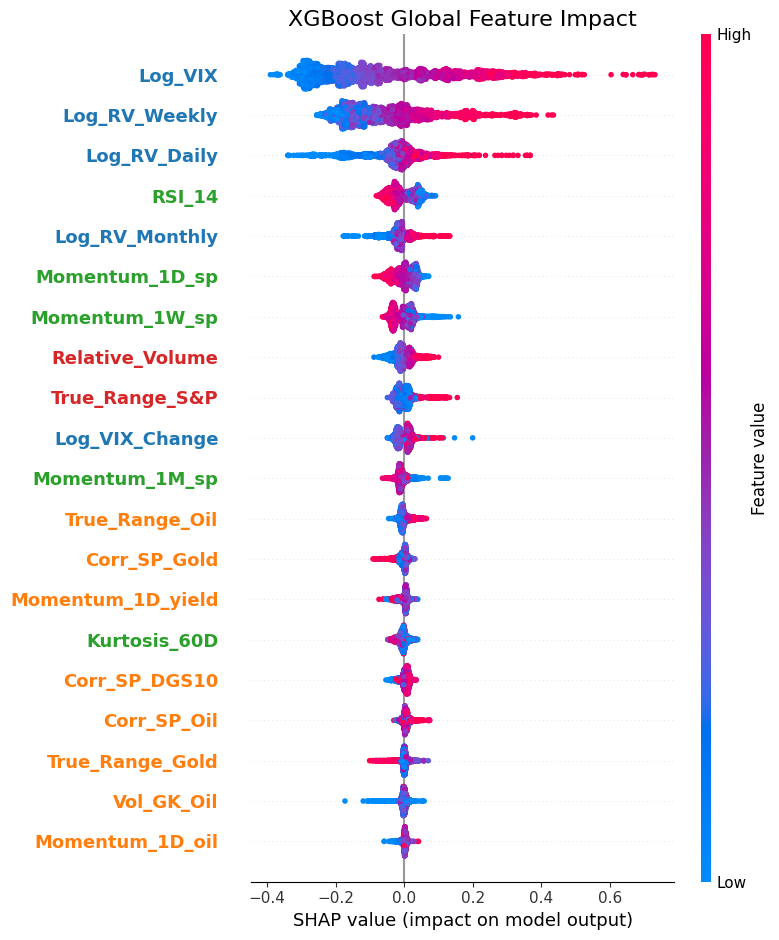

In [43]:
# 2. Extract SHAP values
df_shap = metrics['SHAP_Values']

# 3. Extract matching X values (Features)
# We need the original feature values to color the dots (Red=High, Blue=Low)
X_test_all = df_features.loc[df_shap.index, df_shap.columns]

# 4. Generate the Fixed Beeswarm Plot

# Extract SHAP values
df_shap = metrics['SHAP_Values']

# Extract matching X values (for coloring dots)
X_test_all = df_features.loc[df_shap.index, df_shap.columns]

import shap
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

shap.summary_plot(
    df_shap.values,
    X_test_all,
       # Top 10 by mean |SHAP|
    show=False
)

# ----------------------------------------------------
# POST-PROCESS: Color y-axis labels by feature category
# ----------------------------------------------------
ax = plt.gca()
yticklabels = ax.get_yticklabels()

for label in yticklabels:
    feature_name = label.get_text()
    category = feature_categories.get(feature_name, None)

    if category is not None:
        label.set_color(category_colors.get(category, 'black'))
        label.set_fontweight('bold')

# ----------------------------------------------------
plt.title("XGBoost Global Feature Impact", fontsize=16)
plt.tight_layout()

# Optional save
try:
    save_path = os.path.join(OUT_DIR, 'Shap_values_all_colored_labels.pdf')
    plt.savefig(save_path, format='pdf', bbox_inches='tight')
    print(f"Graph saved to: {save_path}")
except NameError:
    pass

plt.show()



Plot only the stronger ones

Graph saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\Shap_values_top10_colored_labels.pdf


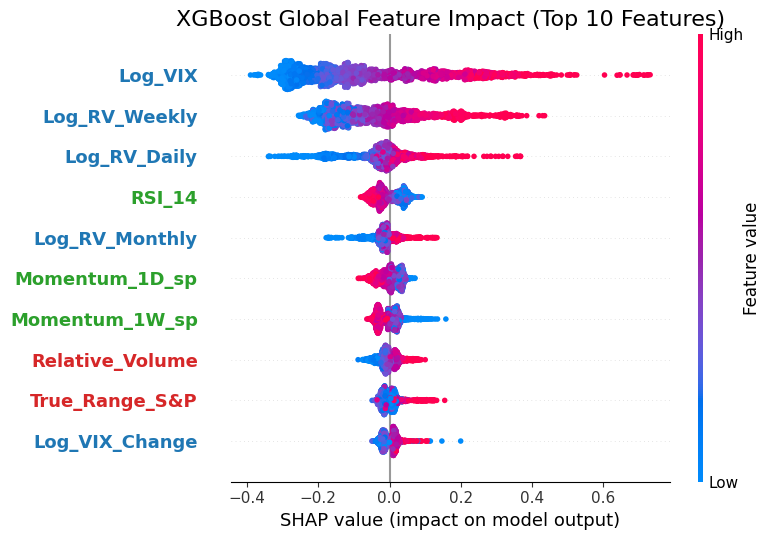

In [ ]:
# Extract SHAP values
df_shap = metrics['SHAP_Values']

# Extract matching X values (for coloring dots)
X_test_all = df_features.loc[df_shap.index, df_shap.columns]

import shap
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

shap.summary_plot(
    df_shap.values,
    X_test_all,
    max_display=10,   # Top 10 by mean |SHAP|
    show=False
)

# ----------------------------------------------------
# POST-PROCESS: Color y-axis labels by feature category
# ----------------------------------------------------
ax = plt.gca()
yticklabels = ax.get_yticklabels()

for label in yticklabels:
    feature_name = label.get_text()
    category = feature_categories.get(feature_name, None)

    if category is not None:
        label.set_color(category_colors.get(category, 'black'))
        label.set_fontweight('bold')

# ----------------------------------------------------
plt.title("XGBoost Global Feature Impact (Top 10 Features)", fontsize=16)
plt.tight_layout()

# Optional save
try:
    save_path = os.path.join(OUT_DIR, 'Shap_values_top10_colored_labels.pdf')
    plt.savefig(save_path, format='pdf', bbox_inches='tight')
    print(f"Graph saved to: {save_path}")
except NameError:
    pass

plt.show()



INTERACTION EFFECTS

Generating 30 Interaction Plots for Top 10 Features: ['Log_VIX', 'Log_RV_Weekly', 'Log_RV_Daily', 'RSI_14', 'Log_RV_Monthly', 'Momentum_1D_sp', 'Momentum_1W_sp', 'Relative_Volume', 'True_Range_S&P', 'Log_VIX_Change']


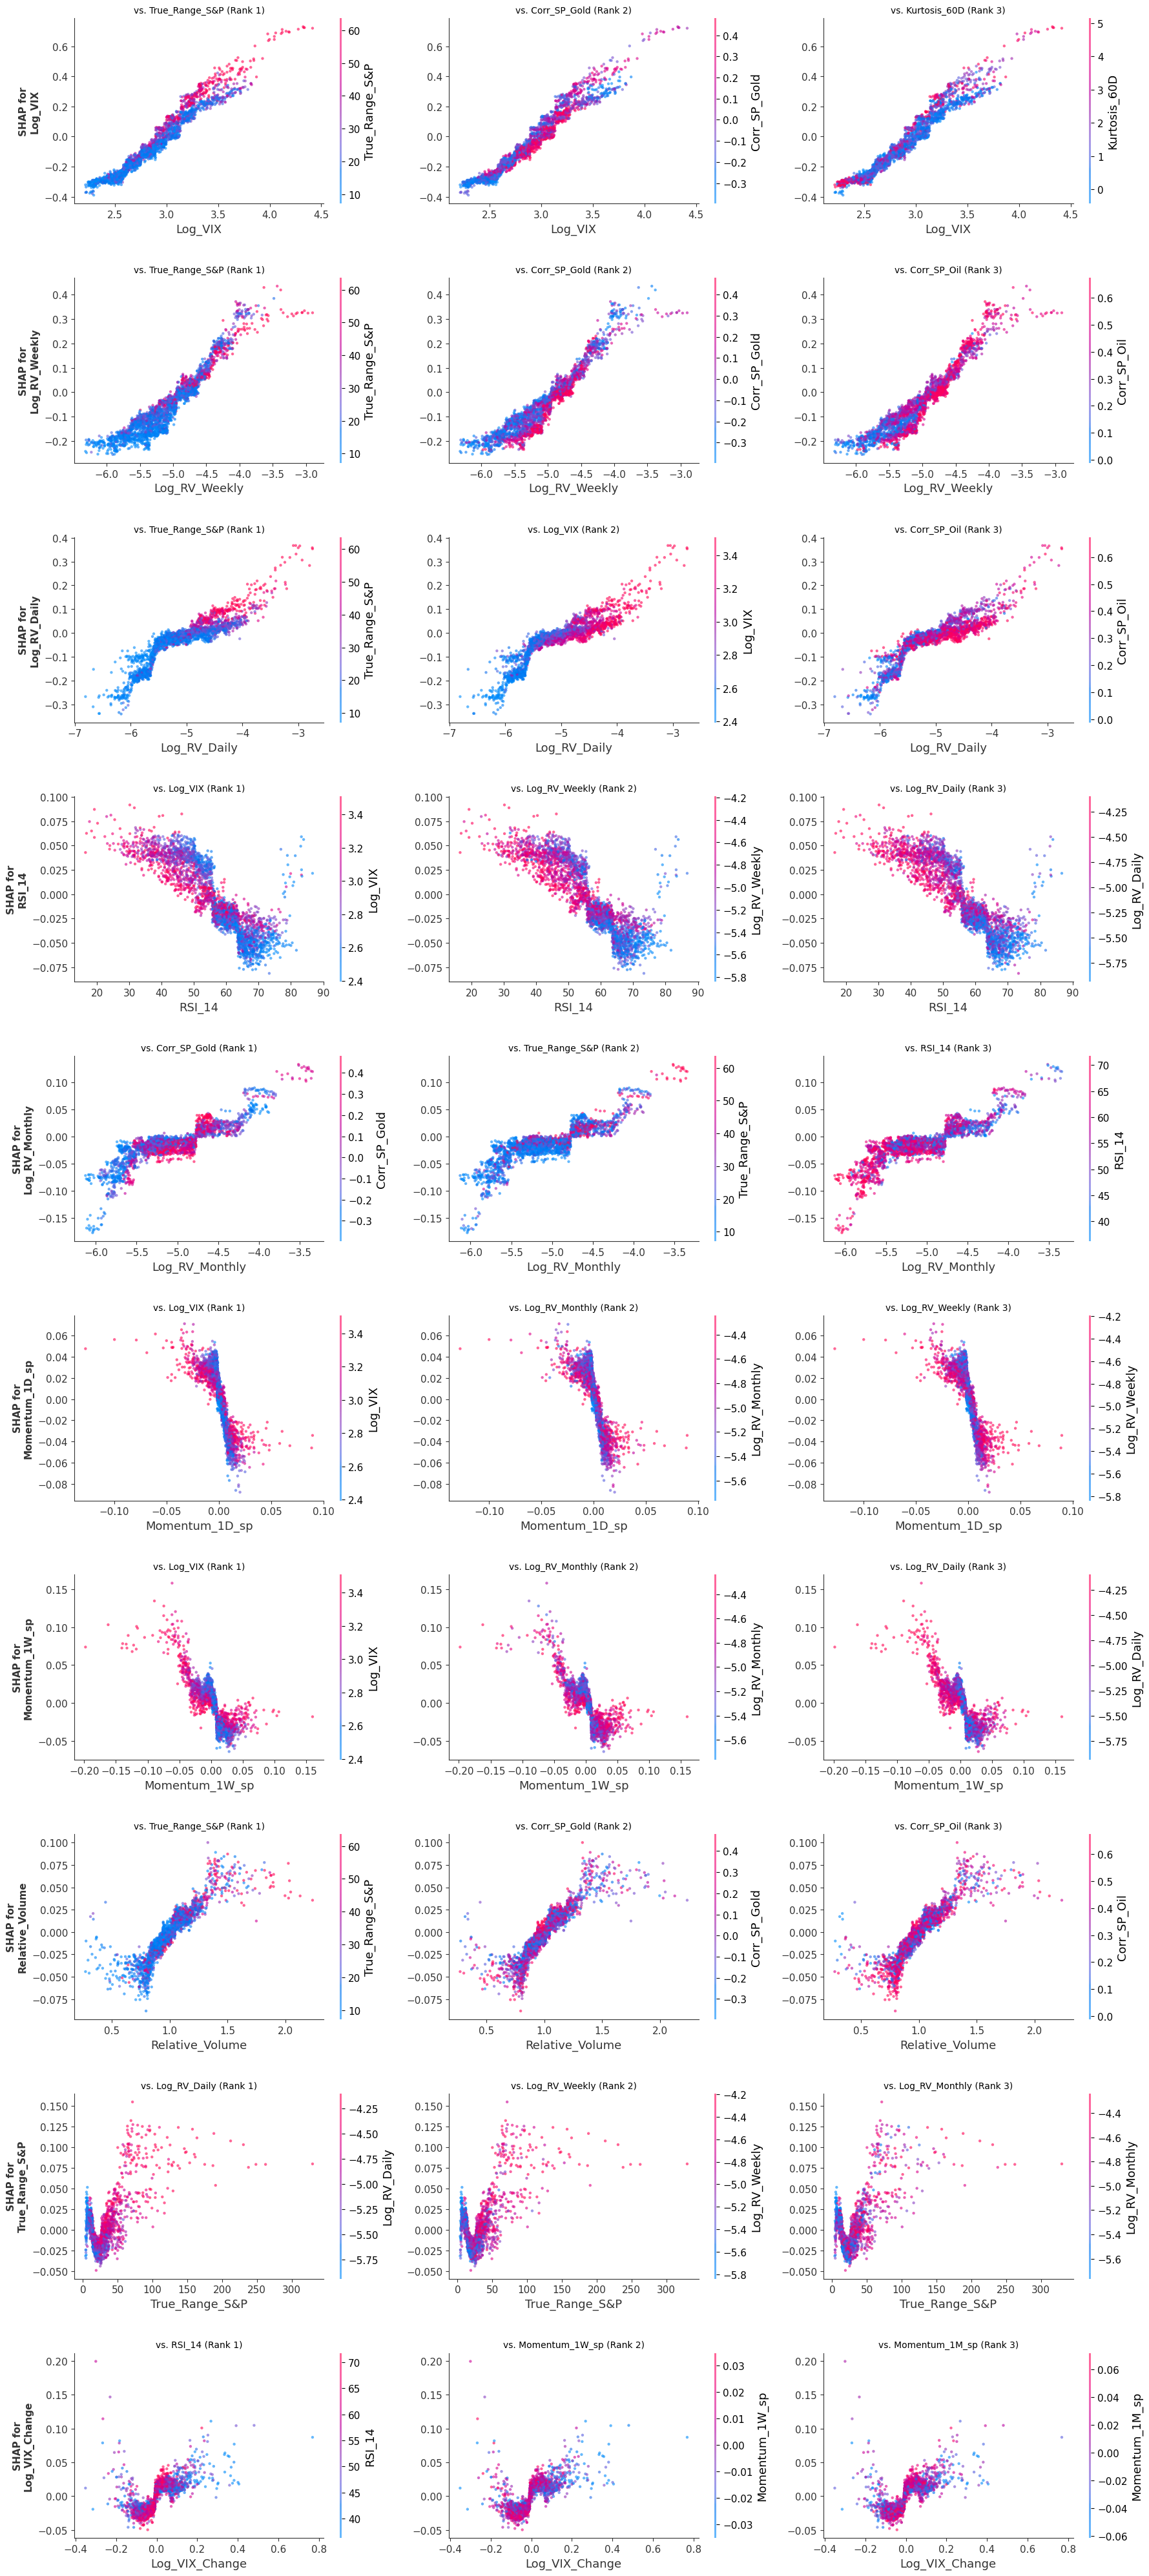

In [30]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_top_10_interactions_gallery(metrics, X_df):
    """
    Generates a massive 10x3 gallery of interaction plots.
    Rows: The Top 10 most important features.
    Columns: The Top 3 strongest interactions for each feature.
    """
    
    # 1. Setup Data
    df_shap = metrics['SHAP_Values']
    # Align feature matrix with SHAP values
    X_subset = X_df.loc[df_shap.index, df_shap.columns]
    
    # 2. Identify Top 10 Features (by Mean Absolute SHAP)
    top_10_features = df_shap.abs().mean().nlargest(10).index.tolist()
    
    print(f"Generating 30 Interaction Plots for Top 10 Features: {top_10_features}")
    
    # 3. Setup Figure (10 Rows, 3 Columns)
    # This will be a TALL image.
    fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(18, 40))
    
    # 4. Main Loop (Per Feature)
    for row_idx, main_feature in enumerate(top_10_features):
        
        # A. Find Top 3 Interactors for this feature
        feature_col_idx = X_subset.columns.get_loc(main_feature)
        
        # approximate_interactions returns indices sorted by strength
        inds = shap.approximate_interactions(
            index=feature_col_idx,
            shap_values=df_shap.values,
            X=X_subset.values
        )
        
        # Filter out self-interaction and take top 3
        top_interactor_inds = [i for i in inds if i != feature_col_idx][:3]
        
        # B. Plot the 3 interactions in the current row
        for col_idx, interactor_idx in enumerate(top_interactor_inds):
            
            interactor_name = X_subset.columns[interactor_idx]
            ax = axes[row_idx, col_idx]
            
            # Plot
            shap.dependence_plot(
                ind=main_feature,
                shap_values=df_shap.values,
                features=X_subset,
                feature_names=X_subset.columns,
                interaction_index=interactor_name, # Forced interaction
                ax=ax,
                show=False,
                alpha=0.6,
                dot_size=10
            )
            
            # Custom Titles
            if col_idx == 0:
                ax.set_ylabel(f"SHAP for\n{main_feature}", fontsize=11, fontweight='bold')
            else:
                ax.set_ylabel("") # Clean up clutter
            
            ax.set_title(f"vs. {interactor_name} (Rank {col_idx+1})", fontsize=10)

    # 5. Final Layout
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4, wspace=0.2) # Add breathing room
    plt.show()

# --- EXECUTION ---
# This will produce a very tall plot. You might want to scroll!
plot_top_10_interactions_gallery(metrics, df_features)

Specific plotting:

Graph saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\Shap_values_interaction_VIX.pdf


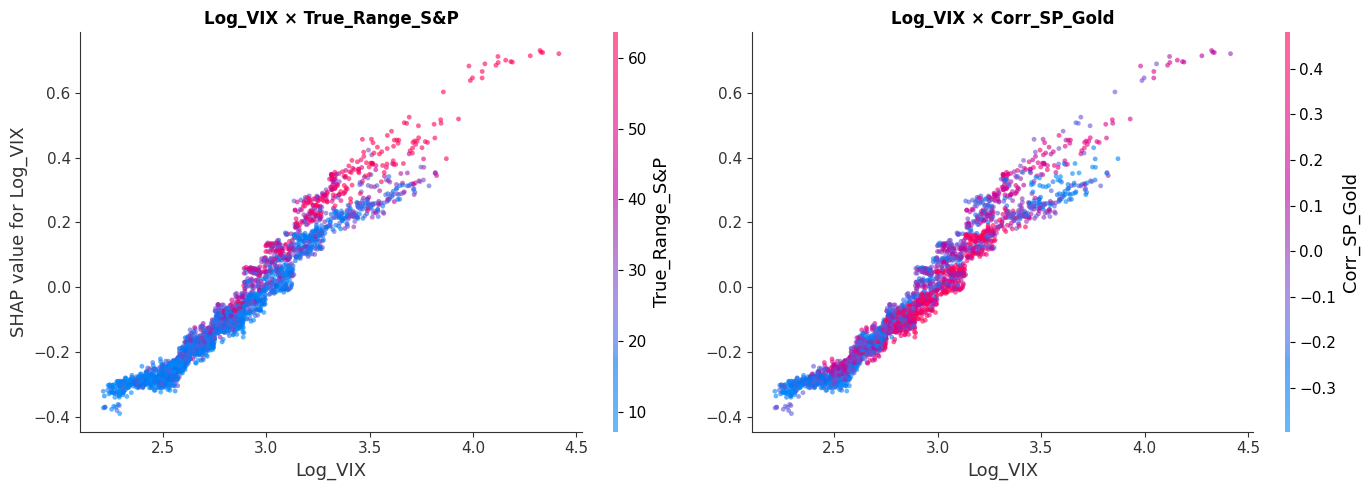

In [ ]:


# --- Data ---
df_shap = metrics['SHAP_Values']
X_subset = df_features.loc[df_shap.index, df_shap.columns]

# --- Create side-by-side figure ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- Left plot: Log_VIX × True_Range_S&P ---
shap.dependence_plot(
    ind="Log_VIX",
    shap_values=df_shap.values,
    features=X_subset,
    feature_names=X_subset.columns,
    interaction_index="True_Range_S&P",
    ax=axes[0],
    show=False,
    alpha=0.6,
    dot_size=12
)
axes[0].set_title("Log_VIX × True_Range_S&P", fontsize=12, fontweight="bold")
axes[0].set_ylabel("SHAP value for Log_VIX")

# --- Right plot: Log_VIX × Corr_SP_Gold ---
shap.dependence_plot(
    ind="Log_VIX",
    shap_values=df_shap.values,
    features=X_subset,
    feature_names=X_subset.columns,
    interaction_index="Corr_SP_Gold",
    ax=axes[1],
    show=False,
    alpha=0.6,
    dot_size=12
)
axes[1].set_title("Log_VIX × Corr_SP_Gold", fontsize=12, fontweight="bold")
axes[1].set_ylabel("")

# --- Layout ---
plt.tight_layout()
try:
    save_path = os.path.join(OUT_DIR, 'Shap_values_interaction_VIX.pdf')
    plt.savefig(save_path, format='pdf', bbox_inches='tight')
    print(f"Graph saved to: {save_path}")
except NameError:
    pass
plt.show()


Graph saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\Shap_values_interaction_side_by_side.pdf


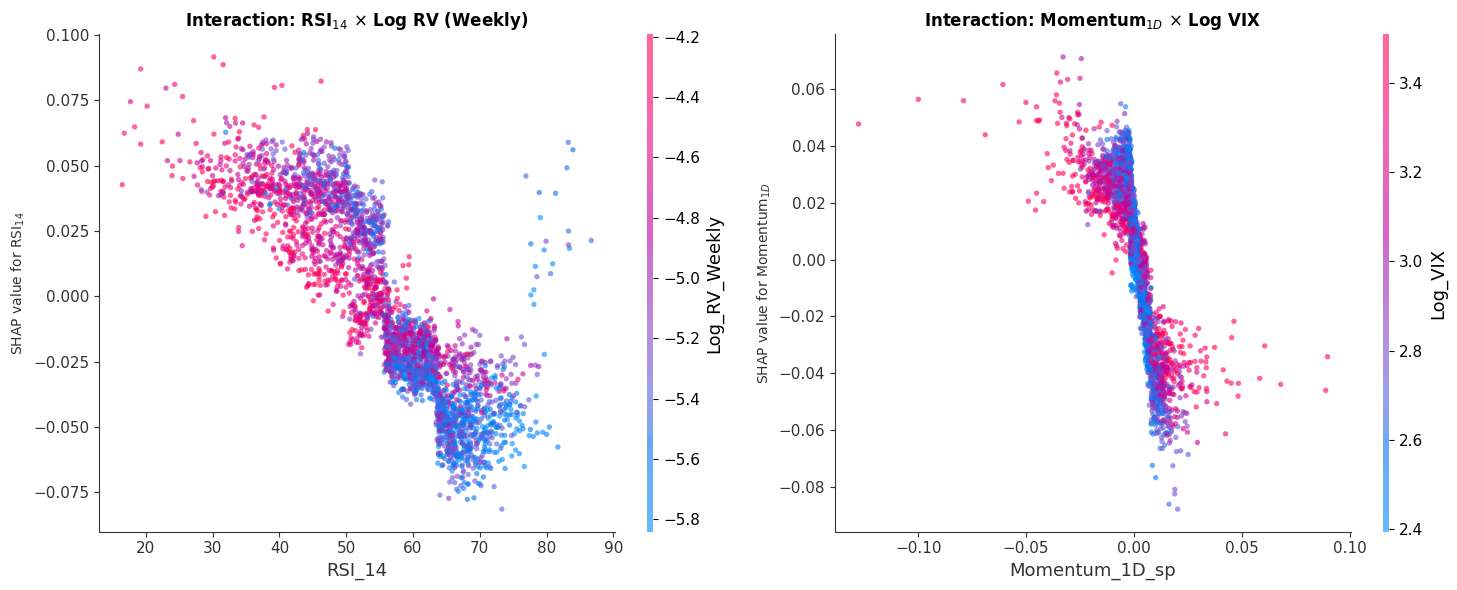

In [14]:
import shap
import matplotlib.pyplot as plt
import os

# --- Extract SHAP values and aligned features ---
# Assurez-vous que df_shap est bien un DataFrame ou un objet compatible
# Si 'metrics' vient de votre code précédent, vérifiez sa structure
df_shap_values = metrics["SHAP_Values"] # Les valeurs SHAP brutes
X_subset = df_features.loc[df_shap_values.index, df_shap_values.columns] # Les features alignées

# --- Create figure: 1 row, 2 columns ---
# figsize=(Largeur, Hauteur) -> (15, 6) donne assez d'espace horizontal
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# ======================================================
# LEFT PANEL: RSI_14 × Log_RV_Weekly
# ======================================================
shap.dependence_plot(
    ind="RSI_14",
    shap_values=df_shap_values.values,
    features=X_subset,
    feature_names=X_subset.columns,
    interaction_index="Log_RV_Weekly",
    ax=axes[0],       # Cible explicite du graphique de gauche
    show=False,       # Important: ne pas afficher tout de suite
    alpha=0.6,
    dot_size=15       # Un peu plus gros pour la lisibilité
)

axes[0].set_title(r"Interaction: RSI$_{14}$ $\times$ Log RV (Weekly)", fontsize=12, fontweight="bold")
axes[0].set_ylabel("SHAP value for RSI$_{14}$", fontsize=10)

# ======================================================
# RIGHT PANEL: Momentum_1D_sp × Log_VIX
# ======================================================
shap.dependence_plot(
    ind="Momentum_1D_sp",
    shap_values=df_shap_values.values,
    features=X_subset,
    feature_names=X_subset.columns,
    interaction_index="Log_VIX",
    ax=axes[1],       # Cible explicite du graphique de droite
    show=False,       # Important
    alpha=0.6,
    dot_size=15
)

axes[1].set_title(r"Interaction: Momentum$_{1D}$ $\times$ Log VIX", fontsize=12, fontweight="bold")
axes[1].set_ylabel("SHAP value for Momentum$_{1D}$", fontsize=10)

# --- Layout & Save ---
plt.tight_layout()

# Création du dossier si nécessaire (juste pour être sûr)
try:
    if 'OUT_DIR' in globals():
        save_path = os.path.join(OUT_DIR, 'Shap_values_interaction_side_by_side.pdf')
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
        print(f"Graph saved to: {save_path}")
    else:
        print("OUT_DIR not defined, skipping save.")
except Exception as e:
    print(f"Could not save graph: {e}")

plt.show()

XGBOOST EGARCH

In [15]:
df = pd.read_csv('data/EGARCH_all_features.csv', index_col=0, parse_dates=True)

In [ ]:
def run_xgboost_sliding_window(
    df,
    feature_cols=None,
    target_col="Target_Log_RV",
    initial_train_size=2000,
    test_window_size=20,
):
    """
    Rolling-window XGBoost forecaster for log realised volatility.

    
    """

    # -------------------------
    # 0. Default feature list
    # -------------------------
    if feature_cols is None:
        feature_cols = [
            'Relative_Volume', 'True_Range_S&P', 'Momentum_1D_gold',
            'Momentum_1D_oil', 'Momentum_1D_yield', 'Corr_SP_Gold', 'Corr_SP_Oil',
            'Corr_SP_DGS10', 'True_Range_Oil', 'True_Range_Gold', 'Vol_GK_Oil',
            'Vol_GK_Gold', 'Log_VIX', 'Log_VIX_Change', 'Log_RV_Daily',
            'Log_RV_Weekly', 'Log_RV_Monthly', 'Kurtosis_60D',
            'Momentum_1D_sp', 'Momentum_1W_sp', 'Momentum_1M_sp', 'RSI_14'
        ]

    # -------------------------
    # 1. Prepare data
    # -------------------------
    data = df.copy()
    data = data.dropna(subset=[target_col])

    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)

    X_all = data[feature_cols]
    y_all = data[target_col].values

    # Storage
    predictions_log = []
    actuals_log = []
    prediction_dates = []

    train_r2_list = []
    val_r2_list = []
    test_r2_list = []
    window_end_dates = []

    # NEW: store feature importances per window
    feature_importance_list = []

    current_idx = initial_train_size
    n_samples = len(data)

    print("Starting rolling XGBoost forecast...")

    # -------------------------
    # 2. Rolling loop
    # -------------------------
    while current_idx < n_samples:

        test_end_idx = min(current_idx + test_window_size, n_samples)
        if test_end_idx <= current_idx:
            break

        print(f"\nWindow: Train[0:{current_idx}] → Test[{current_idx}:{test_end_idx}]")

        # Split
        X_train = X_all.iloc[:current_idx]
        y_train = y_all[:current_idx]

        X_test = X_all.iloc[current_idx:test_end_idx]
        y_test = y_all[current_idx:test_end_idx]
        dates_test = data.index[current_idx:test_end_idx]

        # Chronological train/validation split
        val_fraction = 0.2
        val_size = int(len(X_train) * val_fraction)

        X_train_fit = X_train.iloc[:-val_size]
        y_train_fit = y_train[:-val_size]

        X_val = X_train.iloc[-val_size:]
        y_val = y_train[-val_size:]

        # Hyperparameter grid
        param_grid = {
            "max_depth": [2, 3],
            "learning_rate": [0.05, 0.1],
            "subsample": [0.7, 0.9],
            "colsample_bytree": [0.7, 0.9],
            "reg_lambda": [5, 10],
            "reg_alpha": [0, 1],
        }

        best_val = np.inf
        best_params = None

        # Grid search
        for md, lr, ss, cs, lam, alp in itertools.product(
            param_grid["max_depth"],
            param_grid["learning_rate"],
            param_grid["subsample"],
            param_grid["colsample_bytree"],
            param_grid["reg_lambda"],
            param_grid["reg_alpha"]
        ):
            model = xgb.XGBRegressor(
                objective="reg:squarederror",
                max_depth=md,
                learning_rate=lr,
                subsample=ss,
                colsample_bytree=cs,
                reg_lambda=lam,
                reg_alpha=alp,
                n_estimators=300,
                random_state=42,
                tree_method="hist"
            )

            model.fit(X_train_fit, y_train_fit)
            preds_val = model.predict(X_val)
            val_rmse = np.sqrt(mean_squared_error(y_val, preds_val))

            if val_rmse < best_val:
                best_val = val_rmse
                best_params = (md, lr, ss, cs, lam, alp)

        print("Best params:", best_params)

        # Final model (train + val)
        md, lr, ss, cs, lam, alp = best_params

        final_model = xgb.XGBRegressor(
            objective="reg:squarederror",
            max_depth=md,
            learning_rate=lr,
            subsample=ss,
            colsample_bytree=cs,
            reg_lambda=lam,
            reg_alpha=alp,
            n_estimators=300,
            random_state=42,
            tree_method="hist"
        )

        final_model.fit(X_train, y_train)

        # NEW: store feature importances for this window
        fi = final_model.feature_importances_  # shape (n_features,)
        feature_importance_list.append(fi)

        # In-sample R² (train / val)
        train_pred = final_model.predict(X_train_fit)
        val_pred = final_model.predict(X_val)

        train_r2 = r2_score(y_train_fit, train_pred)
        val_r2 = r2_score(y_val, val_pred)

        # Test predictions
        pred_test = final_model.predict(X_test)
        test_r2 = r2_score(y_test, pred_test)

        # Store
        predictions_log.extend(pred_test)
        actuals_log.extend(y_test)
        prediction_dates.extend(dates_test)

        train_r2_list.append(train_r2)
        val_r2_list.append(val_r2)
        test_r2_list.append(test_r2)
        window_end_dates.append(dates_test[-1])

        current_idx += test_window_size

    # -------------------------
    # 3. Final metrics (vol levels)
    # -------------------------
    pred_log = np.array(predictions_log)
    actual_log = np.array(actuals_log)

    pred_vol = np.exp(pred_log)
    actual_vol = np.exp(actual_log)

    mse = mean_squared_error(actual_vol, pred_vol)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_vol, pred_vol)

    ss_res = np.sum((actual_vol - pred_vol) ** 2)
    ss_tot = np.sum((actual_vol - actual_vol.mean()) ** 2)
    r2_mean = 1 - ss_res / ss_tot

    y_true = actual_vol
    y_pred = pred_vol
    y_lag = y_true[:-1]
    y_now = y_true[1:]
    y_pred_now = y_pred[1:]

    num = np.sum((y_now - y_pred_now) ** 2)
    den = np.sum((y_now - y_lag) ** 2)
    r2_rw = 1 - num / den

    print("\n====== XGBoost Rolling Forecast Performance ======")
    print(f"RMSE (vol):            {rmse:.6f}")
    print(f"MAE  (vol):            {mae:.6f}")
    print(f"R2 (vs mean, XGBoost): {r2_mean:.6f}")
    print(f"R2 (vs RW, XGBoost):   {r2_rw:.6f}")
    print("=================================================")

    # -------------------------
    # 4. Plots
    # -------------------------
    # R² per window (on log-vol)
    r2_df = pd.DataFrame({
        "Train_R2": train_r2_list,
        "Val_R2": val_r2_list,
        "Test_R2": test_r2_list
    }, index=pd.to_datetime(window_end_dates))

    plt.figure(figsize=(14, 6))
    plt.plot(r2_df.index, r2_df["Train_R2"], label="Train R²", linewidth=1.6)
    plt.plot(r2_df.index, r2_df["Val_R2"], label="Validation R²", linewidth=1.4)
    plt.plot(r2_df.index, r2_df["Test_R2"], label="Test R²", linewidth=1.8)
    plt.axhline(0, linestyle="--", color="black", alpha=0.7)
    plt.title("Rolling Window R² (XGBoost) — Train / Val / Test", fontsize=14, fontweight="bold")
    plt.ylabel("R² (on log-vol)")
    plt.xlabel("Window End Date")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Realised vs predicted volatility
    results_df = pd.DataFrame({
        "Pred_Log": pred_log,
        "True_Log": actual_log
    }, index=pd.to_datetime(prediction_dates))

    results_df["Pred_Vol"] = np.exp(results_df["Pred_Log"])
    results_df["True_Vol"] = np.exp(results_df["True_Log"])

    plt.figure(figsize=(15, 6))
    plt.plot(results_df.index, results_df["True_Vol"],
             color="grey", alpha=0.6, linewidth=1.0, label="Realised Volatility")
    plt.plot(results_df.index, results_df["Pred_Vol"],
             color="#C0392B", linewidth=1.4, label="XGBoost Forecast")
    plt.title("Realised Volatility vs XGBoost Forecast", fontsize=14, fontweight="bold")
    plt.ylabel("Daily Volatility (level)")
    plt.xlabel("Date")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()
    plt.tight_layout()

    try:
        save_path = os.path.join(OUT_DIR, 'xgboost_EGARCH_forecast_results.pdf')
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
        print(f"Graph saved to: {save_path}")
    except NameError:
        print("Could not save PDF (OUT_DIR not defined).")

    plt.show()

    # -------------------------
    # 5. Build feature importance DF
    # -------------------------
    fi_matrix = np.vstack(feature_importance_list)  # shape: (n_windows, n_features)
    fi_df = pd.DataFrame(
        fi_matrix,
        index=pd.to_datetime(window_end_dates),
        columns=feature_cols
    )

    # -------------------------
    # 6. Return objects
    # -------------------------
    metrics = {
        "RMSE": rmse,
        "MAE": mae,
        "R2_mean": r2_mean,
        "R2_RW": r2_rw,
        "R2_windows": r2_df,
        "Feature_Importance": fi_df
    }

    return results_df, metrics


Starting rolling XGBoost forecast...

Window: Train[0:2000] → Test[2000:2020]
Best params: (2, 0.1, 0.9, 0.7, 10, 0)

Window: Train[0:2020] → Test[2020:2040]
Best params: (2, 0.1, 0.9, 0.7, 5, 1)

Window: Train[0:2040] → Test[2040:2060]
Best params: (2, 0.1, 0.9, 0.7, 5, 0)

Window: Train[0:2060] → Test[2060:2080]
Best params: (2, 0.1, 0.9, 0.7, 5, 0)

Window: Train[0:2080] → Test[2080:2100]
Best params: (2, 0.1, 0.9, 0.9, 5, 1)

Window: Train[0:2100] → Test[2100:2120]
Best params: (3, 0.1, 0.7, 0.7, 5, 0)

Window: Train[0:2120] → Test[2120:2140]
Best params: (2, 0.1, 0.9, 0.9, 10, 0)

Window: Train[0:2140] → Test[2140:2160]
Best params: (2, 0.1, 0.9, 0.7, 10, 0)

Window: Train[0:2160] → Test[2160:2180]
Best params: (2, 0.1, 0.7, 0.7, 5, 1)

Window: Train[0:2180] → Test[2180:2200]
Best params: (2, 0.1, 0.9, 0.7, 5, 1)

Window: Train[0:2200] → Test[2200:2220]
Best params: (2, 0.1, 0.9, 0.9, 5, 0)

Window: Train[0:2220] → Test[2220:2240]
Best params: (2, 0.1, 0.9, 0.7, 10, 0)

Window: Tr

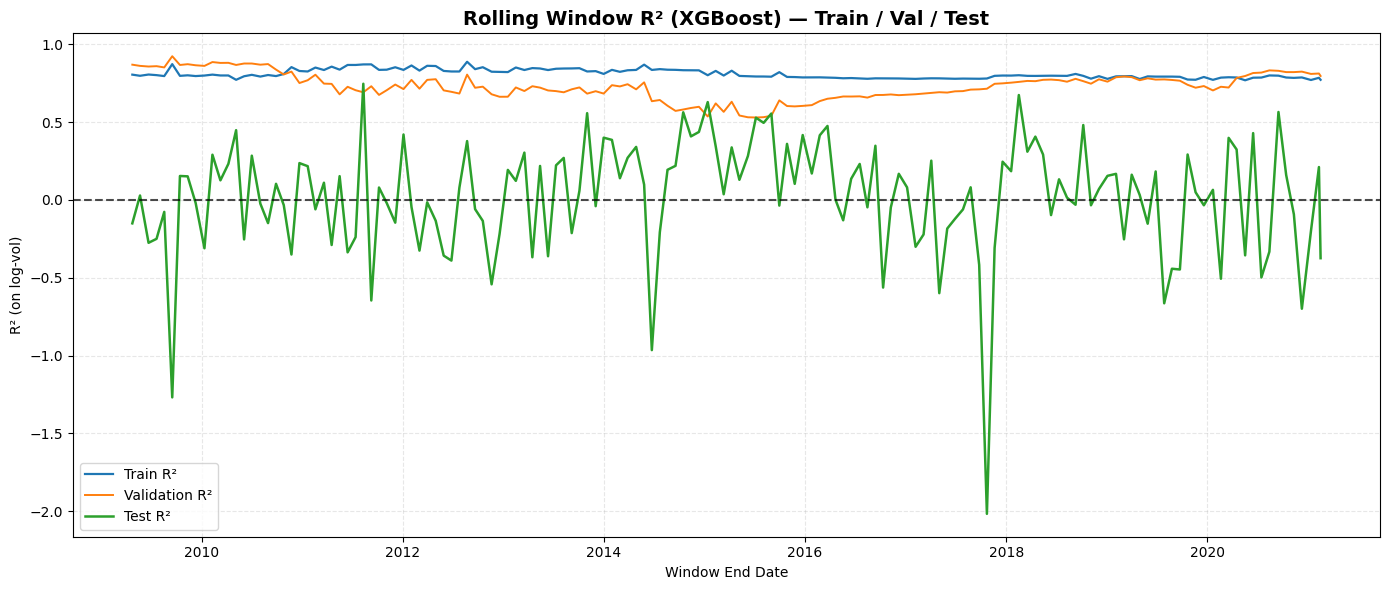

Graph saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\xgboost_EGARCH_forecast_results.pdf


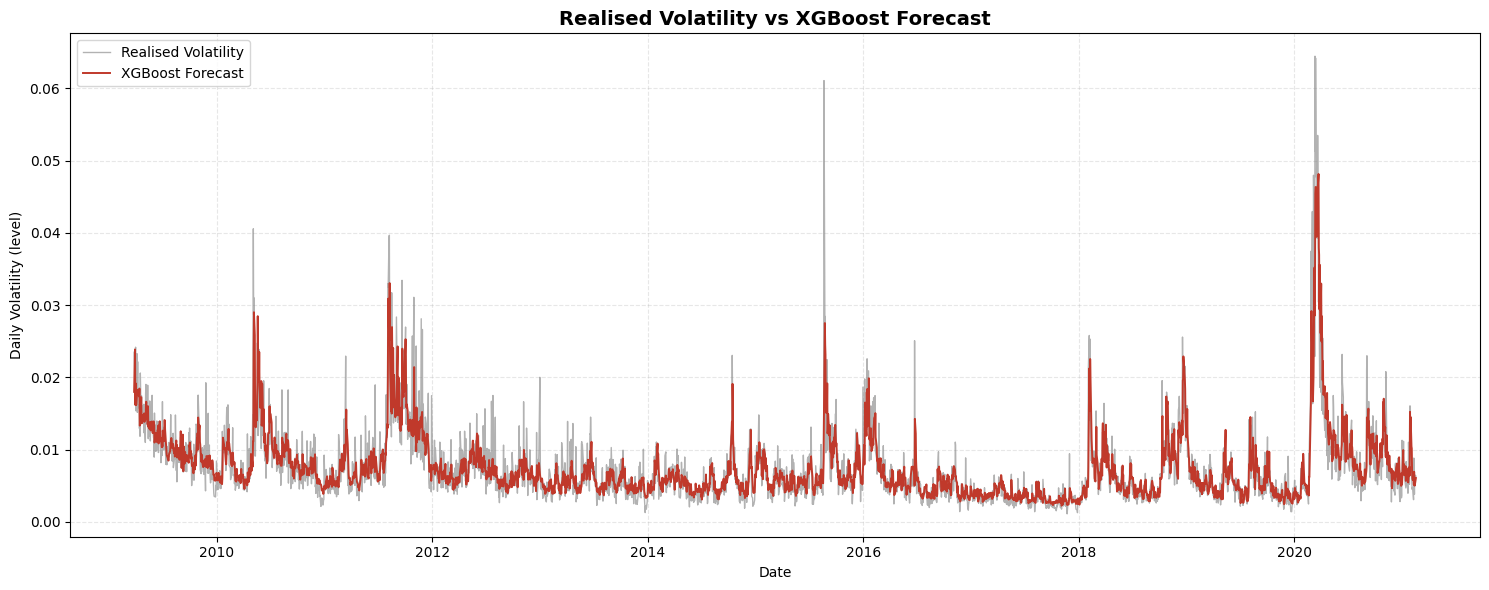

In [17]:
results_xgb, metrics_xgb = run_xgboost_sliding_window(df)